In [41]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import os
import matplotlib.pyplot as plt

In [42]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224  # GoogLeNet typically uses 224x224 input size
CHANNELS = 3
EPOCHS = 50
n_classes = 3

In [43]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/new-dataset/PlantVillage/x",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1998 files belonging to 3 classes.


In [44]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    
    return train_ds, val_ds

In [45]:
train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [67]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/new-dataset/PlantVillage/test",  # Replace with correct path
    seed=123,
    shuffle=False,  # No need to shuffle test data
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 120 files belonging to 3 classes.


In [47]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [48]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[2 1 2 1 1 2 1 0 2 0 1 1 1 1 0 0 2 1 0 1 0 2 0 1 0 1 2 2 1 1 0 2]


In [49]:
len(dataset)

63

In [50]:
train_size = 0.8
len(dataset)*train_size

50.400000000000006

In [51]:
train_ds = dataset.take(54)
len(train_ds)

54

In [52]:
#test_ds = dataset.skip(54)
#len(test_ds)

In [53]:
val_size=0.1
len(dataset)*val_size

6.300000000000001

In [54]:
val_ds = test_ds.take(6)
len(val_ds)

4

In [55]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [56]:
class_names = dataset.class_names

In [57]:

# Prefetch the datasets for efficiency
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [58]:
def inception_module(x, f1, f3_r, f3, f5_r, f5, pool_proj):
    conv1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    conv3 = layers.Conv2D(f3_r, (1, 1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3)

    conv5 = layers.Conv2D(f5_r, (1, 1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5)

    pool_proj_layer = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj_layer = layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(pool_proj_layer)

    output = layers.concatenate([conv1, conv3, conv5, pool_proj_layer], axis=-1)
    return output


In [59]:
input_layer = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

In [60]:
# Inception layers
x = inception_module(x, 64, 96, 128, 16, 32, 32)
x = inception_module(x, 128, 128, 192, 32, 96, 64)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 192, 96, 208, 16, 48, 64)
x = inception_module(x, 160, 112, 224, 24, 64, 64)
x = inception_module(x, 128, 128, 256, 24, 64, 64)
x = inception_module(x, 112, 144, 288, 32, 64, 64)
x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, 256, 160, 320, 48, 128, 128)
x = inception_module(x, 384, 192, 384, 48, 128, 128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output_layer = layers.Dense(n_classes, activation='softmax')(x)

In [61]:
model = models.Model(input_layer, output_layer)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [62]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 56, 56,    │          0 │ conv2d_57[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 56, 56,    │    110,784 │ conv2d_58[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 28, 28,    │          0 │ conv2d_59[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 28, 28,    │     18,528 │ max_pooling2d_14… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 28, 28,    │      3,088 │ max_pooling2d_14… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 28, 28,    │          0 │ max_pooling2d_14… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 28, 28,    │     12,352 │ max_pooling2d_14… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 28, 28,    │    110,720 │ conv2d_61[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 28, 28,    │     12,832 │ conv2d_63[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 28, 28,    │      6,176 │ max_pooling2d_15… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 28, 28,    │          0 │ conv2d_60[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_62[0][0],  │
│                     │                   │            │ conv2d_64[0][0],  │
│                     │                   │            │ conv2d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 28, 28,    │     32,896 │ concatenate_9[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate_9[0]… │
│                     │ 32)               │            │                 

 Total params: 6,041,155 (23.05 MB)

 Trainable params: 6,041,155 (23.05 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 146ms/step - accuracy: 0.3862 - loss: 1.8853 - val_accuracy: 0.3333 - val_loss: 1.1373
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4060 - loss: 1.0803 - val_accuracy: 0.4417 - val_loss: 1.0984
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4310 - loss: 1.0638 - val_accuracy: 0.3333 - val_loss: 1.1063
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4246 - loss: 1.0706 - val_accuracy: 0.3333 - val_loss: 1.1035
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4153 - loss: 1.0678 - val_accuracy: 0.3333 - val_loss: 1.1058
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4456 - loss: 1.0662 - val_accuracy: 0.3417 - val_loss: 1.1217
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.4044 - loss: 1.0827 - val_accuracy: 0.3333 - val_loss: 1.1562
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.4011 - loss: 1.0806 - val_accuracy: 0.3333 -

In [68]:
# Evaluate the model on the test dataset
if len(test_ds) > 0:
    try:
        scores = model.evaluate(test_ds)
        print(f"Test Accuracy: {scores[1] * 100:.2f}%")
    except ValueError as e:
        print(f"Error during model evaluation: {e}")
else:
    print("Test dataset is empty. Please check the dataset.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6854 - loss: 1.4918   
Test Accuracy: 50.00%


In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

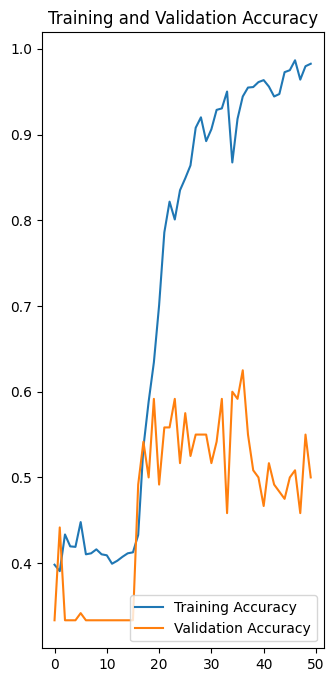

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


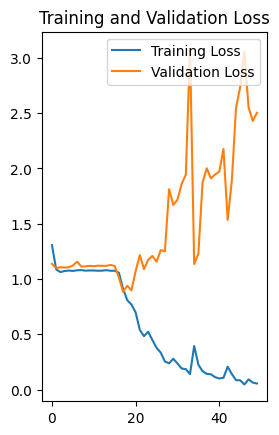

In [72]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: Potato___Early_blight


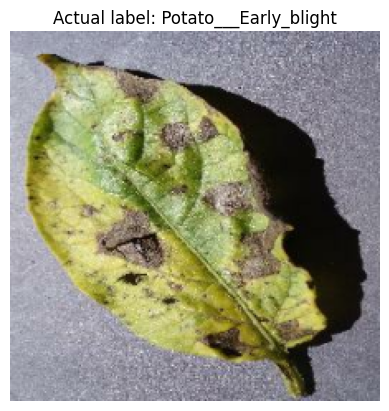

In [73]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.title(f"Actual label: {dataset.class_names[first_label]}")
    plt.axis('off')

    batch_prediction = model.predict(images_batch)
    print("Predicted label:", dataset.class_names[np.argmax(batch_prediction[0])])

In [74]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")


In [ ]:
model.save("../potatoes.h5")

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming `model` is already trained and `test_ds` is the test dataset

# Step 1: Get true labels and predicted labels from the test dataset
y_true = []  # Actual labels
y_pred = []  # Predicted labels

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())  # Add the actual labels
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=-1))  # Add the predicted labels

# Step 2: Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print classification report for detailed metrics
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


In [ ]:
def preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to match input size for the model
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    return img_array


In [ ]:
def predict_image(img):
    img_array = preprocess_image(img)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

In [ ]:
def select_image():
    global img_label, img_path
    img_path = filedialog.askopenfilename()
    if img_path:
        img = Image.open(img_path)
        img = img.resize((224, 224))  # Resize for display
        img_tk = ImageTk.PhotoImage(img)
        img_label.config(image=img_tk)
        img_label.image = img_tk

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image



In [ ]:
# Load the trained model (Assuming the model is already saved as 'potatoes.h5')
model = tf.keras.models.load_model('../potatoes.h5')

# Set the image size and class names (should be consistent with training)
IMAGE_SIZE = 224  # GoogLeNet typically uses 224x224 input size
class_names = ['Potato___healthy', 'Potato___Early_blight', 'Potato___Late_blight']  # Replace with your class names



In [ ]:
# Function to preprocess the image and make predictions
def predict_image(img_path):
    # Load the image from file
    img = Image.open(img_path)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))  # Resize image to 224x224
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch size of 1
    img_array = img_array / 255.0  # Normalize the image

    # Predict the class of the image using the model
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the class with highest probability
    confidence = round(100 * np.max(predictions), 2)  # Get confidence score

    # Return the predicted class and confidence
    return class_names[predicted_class], confidence



In [ ]:
# Example function to upload and test an image from file manager (for demonstration purposes)
def test_uploaded_image(img_path):
    # Predict the class of the uploaded image
    predicted_class, confidence = predict_image(img_path)

    # Load and display the image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}, Confidence: {confidence}%")
    plt.show()

    # Print the result
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence}%")



In [ ]:
# Example usage
# Replace 'path_to_image/leaf_image.jpg' with the actual path to the image from the file manager
test_uploaded_image('/kaggle/input/example/0b092cda-db8c-489d-8c46-23ac3835310d___RS_LB 4480.JPG')
